# Homework 4: Evaluation Metrics for Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('bank-full.csv',
                   sep=';', 
                   quotechar='"',
                   encoding='utf-8')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
selected_columns = ['age', 'job', 'marital', 'education',  'balance', 'housing',
                    'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
                    'previous', 'poutcome', 'y']

df_selected = df.copy()[selected_columns]
df_selected.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


### Target encoding

In [4]:
df_selected.y = (df_selected.y == 'yes').astype(int)
df_selected.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,0


## Split the data

Split your data in train/val/test sets with 60%/20%/20% distribution. Use Scikit-Learn for that (the train_test_split function) and set the seed to 42. Make sure that the target value y is not in your dataframe.

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
df_full_train, df_test = train_test_split(df_selected, test_size = 0.2, random_state = 1)

In [7]:
len(df_full_train), len(df_test)

(36168, 9043)

In [8]:
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)
len(df_train), len(df_val)

(27126, 9042)

In [9]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

In [10]:
del df_train["y"]
del df_val["y"]
del df_test["y"]

In [11]:
df_full_train.y.value_counts(normalize= True)

y
0    0.882797
1    0.117203
Name: proportion, dtype: float64

## Question 1: ROC AUC feature importance

In [12]:
numerical = list(df_train.dtypes[df_train.dtypes == 'int64'].index)
numerical

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [13]:
categorical = list(df_train.dtypes[df_train.dtypes == 'object'].index)
categorical

['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

## Question 2: Training the model

### One hot encoding

In [14]:
from sklearn.feature_extraction import DictVectorizer

In [15]:
train_dicts = df_train[categorical + numerical].to_dict(orient = 'records')

In [16]:
dv = DictVectorizer(sparse = False)

In [17]:
X_train = dv.fit_transform(train_dicts)

In [18]:
val_dicts = df_val[categorical + numerical].to_dict(orient = 'records')
X_val = dv.fit_transform(val_dicts)

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
_ = model.fit(X_train, y_train)

In [21]:
y_pred = model.predict_proba(X_val)[:,1]

In [22]:
from sklearn.metrics import roc_curve

In [23]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

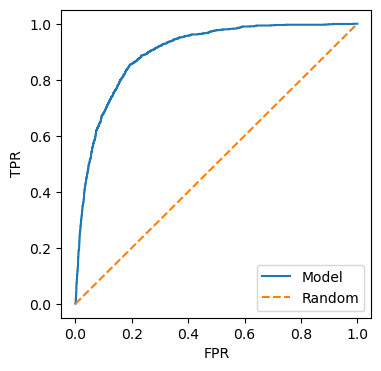

In [24]:
plt.figure(figsize=(4, 4))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()
plt.show()

### AUC
What's the AUC of this model on the validation dataset? 

In [25]:
from sklearn.metrics import auc

In [26]:
print(f'The AUC on the validation set is. {auc(fpr, tpr):.3f}')

The AUC on the validation set is. 0.900


## Question 3: Precision and Recall

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

In [27]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [28]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

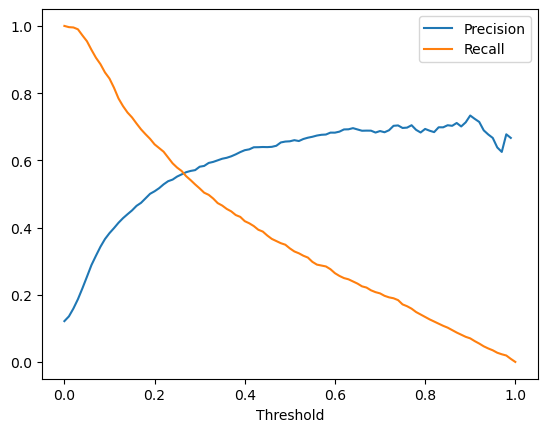

In [32]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()

Precision and recall intersect at around 0.265.

## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1: F1 score = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [30]:
df_scores['F1'] = 2*df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall )

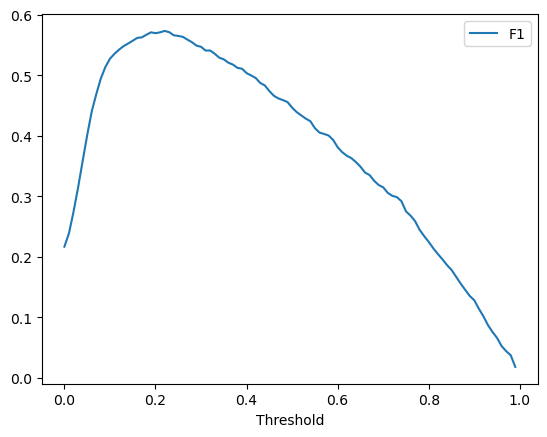

In [34]:
plt.plot(df_scores.threshold, df_scores['F1'], label='F1')
plt.xlabel('Threshold')
plt.legend()
plt.show()

F1 score is maximal at the threshold of 0.22. This is quite close the the threshold where the precision and recall intersects. Could there be a relationship between the threshold at which the F1 score is maximized and where the precision and recall intersect?

## Question 5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

In [36]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [37]:
dv, model = train(df_train, y_train, C=1.0)

In [38]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [39]:
y_pred = predict(df_val, dv, model)

In [40]:
from sklearn.model_selection import KFold

In [41]:
!pip install tqdm